# Basic Evaluation of the trained model
The idea is to compare the predicted missing frame to the linearly interpolated frame, for a given frame gap.

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import h5py
import keras
from keras.models import load_model
from ssim_loss import *
import keras.backend as K

import tensorflow as tf
from ssim_loss import ssim_loss


from skimage.measure import compare_mse as mse
from skimage.measure._structural_similarity import structural_similarity as ssim

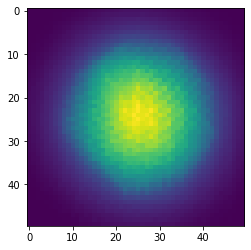

In [2]:
data_sample = "./Aberated/npys/numpy_stack_tomviz_50x50_Deca_Ag_(151, 230, 91)_None_None_None_3_6_3_10.npy"
data_array = np.load(data_sample)
frame = 1

plt.figure()
plt.imshow(data_array[:, :, frame])

In [3]:
def compute_lin_interpolation(img_block):
    batch_size, h, w, stacked = img_block.shape
    return np.mean(img_block, axis=-1)

def predicted_frame(img_block, model):
    return model.predict(input_block)

def compute_mse(img1, img2):
    assert img1.shape == img2.shape
    batchsize, h, w = img1.shape
    out = 0.
    for item in range(batchsize):
        out += mse(img1[item, :, :], img2[item, :, :])
    return out/batchsize

def compute_ssim(img1, img2):
    assert img1.shape == img2.shape
    batchsize, h, w = img1.shape
    out = 0.
    for item in range(batchsize):
        # same parameters used for training the model
        out += ssim(img1, img2, win_size=11, data_range=1.0, sigma=1.5, k1=0.01, k2=0.03)
    return out/batchsize

In [27]:
file_name = "aberrated_hdf5/frame_gaps_4_aberrated.hdf5"
def main(filename, model, batchsize=64):
    ssims = []
    mses = []
    x_axis = []
    x = 0
    f = h5py.File(filename)
    x_val = np.array(f['x_val'])
    y_val = np.array(f['y_val'])
    num_samples = x_val.shape[0]
    for i in range(0, int(num_samples/batchsize)*batchsize, batchsize):
        predicted_frames = model.predict(x_val[i:i+batchsize, :, :, :])
        interpolated_frames = compute_lin_interpolation(x_val[i:i+batchsize, :, :, :])
        target_block = y_val[i:i+batchsize, :, :]
        ssims.append((compute_ssim(predicted_frames, target_block), compute_ssim(interpolated_frames, target_block)))
        mses.append((compute_mse(predicted_frames, target_block), compute_mse(interpolated_frames, target_block)))
        x_axis.append(x)
        x+=1
        print("%d batch are processed, %d are left ..."%(i/64, int(num_samples/batchsize)-(i/64)))
    
    return mses, ssims, x_axis

In [28]:
model = load_model("frame_gaps_12_aberated_model.h5", {'ssim_loss': ssim_loss})


In [29]:
mses, ssims, x_axis = main(file_name, model, 64)

/home/mohamadt/anaconda/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  import sys
/home/mohamadt/anaconda/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]


0 batch are processed, 335 are left ...
1 batch are processed, 334 are left ...
2 batch are processed, 333 are left ...
3 batch are processed, 332 are left ...
4 batch are processed, 331 are left ...
5 batch are processed, 330 are left ...
6 batch are processed, 329 are left ...
7 batch are processed, 328 are left ...
8 batch are processed, 327 are left ...
9 batch are processed, 326 are left ...
10 batch are processed, 325 are left ...
11 batch are processed, 324 are left ...
12 batch are processed, 323 are left ...
13 batch are processed, 322 are left ...
14 batch are processed, 321 are left ...
15 batch are processed, 320 are left ...
16 batch are processed, 319 are left ...
17 batch are processed, 318 are left ...
18 batch are processed, 317 are left ...
19 batch are processed, 316 are left ...
20 batch are processed, 315 are left ...
21 batch are processed, 314 are left ...
22 batch are processed, 313 are left ...
23 batch are processed, 312 are left ...
24 batch are processed, 31

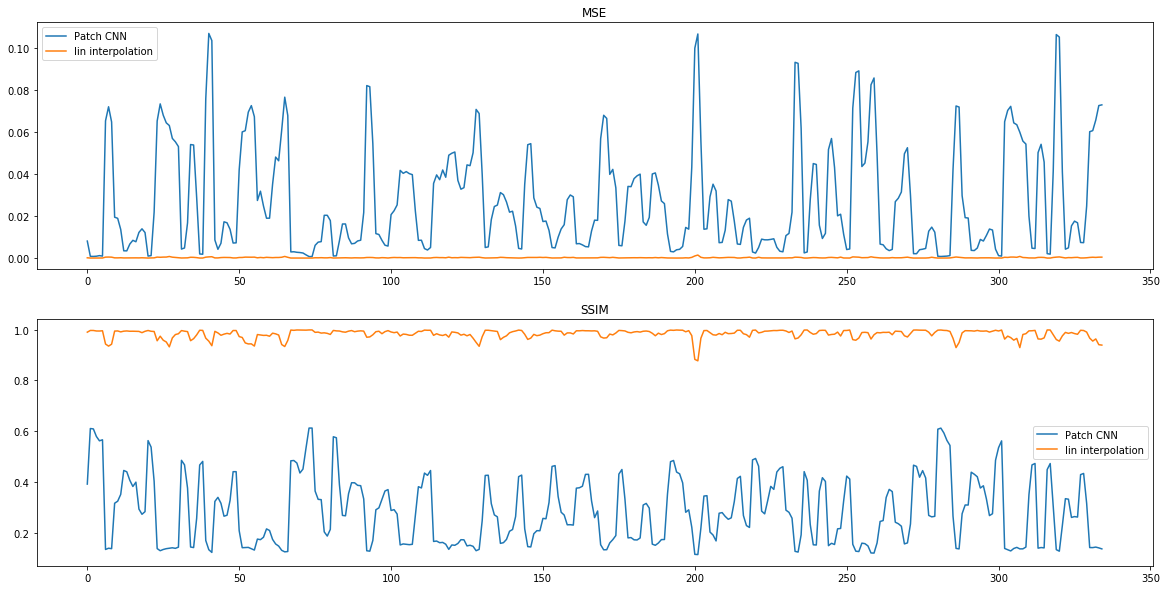

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))

axs[0].plot(x_axis, [i[0] for i in mses], label="Patch CNN")
axs[0].plot(x_axis, [i[1] for i in mses], label="lin interpolation")
axs[0].set_title('MSE')
axs[0].legend()
axs[1].plot(x_axis, [i[0] for i in ssims], label="Patch CNN")
axs[1].plot(x_axis, [i[1] for i in ssims], label="lin interpolation")
axs[1].set_title('SSIM')
axs[1].legend()